In [21]:
import os
import numpy as np
import json
from skimage.draw import polygon
from PIL import Image
import matplotlib.pyplot as plt
from monai.losses import DiceLoss
from monai.networks.nets import UNet
from monai.networks.layers import Norm
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torchvision.utils as vutils
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import time
import copy
import cv2

In [22]:
import json

with open('train.json', 'r') as f:
    data = json.load(f)

In [23]:
root = '/Users/menelaos/Desktop/U-Nets'
image_dir = os.path.join(root, r'/Users/menelaos/Desktop/U-Nets/images/livecell_train_val_images')

### Process the masks based on .json file

In [24]:
# Get name of each image
image_name_list = []
files = os.listdir(image_dir)
for file in files:
    name, extension = os.path.splitext(file)
    if extension == '.png':
        image_name_list.append(name)

In [25]:
image_id_to_segmentation = {}

# Collecting segmentation for each image_id
for image in data['images']:
    name, extension = os.path.splitext(image["file_name"])
    if name in image_name_list:
        image_id = image['id']
        segmentation_list = []
        for ann in data['annotations']:
            if ann['image_id'] == image_id:
                # Create a list of segmentation for each image, each list have corresponding (x, y) coordinate
                segmentation_list += ann['segmentation']
        image_id_to_segmentation[image_id] = {}
        image_id_to_segmentation[image_id]['segmentation'] = segmentation_list
        image_id_to_segmentation[image_id]['name'] = name

In [26]:
shape = (521, 705)

# Create a mask for corresponding image id
for image_id in image_id_to_segmentation.keys():
    combined_mask = np.zeros(shape, dtype=np.float32)
    segmentation_list = image_id_to_segmentation[image_id]['segmentation']
    for segmentation in segmentation_list:
        mask = np.zeros(shape, dtype=np.float32)
        rr, cc = polygon(segmentation[1::2], segmentation[0::2])
        mask[rr, cc] = 1
        combined_mask += mask
    name = image_id_to_segmentation[image_id]['name']
    # Save mask as gray scale image
    plt.imsave(rf'dataset/train_masks/{name}.png', combined_mask, cmap='gray')
    img_pil = Image.open(rf'dataset/train_masks/{name}.png')
    img_pil = img_pil.convert('L')
    img_pil.save(os.path.join(root, rf'dataset/train_masks/{name}.png'))

In [27]:
image = plt.imread(r'/Users/menelaos/Desktop/U-Nets/test_image/train_masks/A172_Phase_A7_1_00d00h00m_1.png')


FileNotFoundError: [Errno 2] No such file or directory: '/Users/menelaos/Desktop/U-Nets/test_image/train_masks/A172_Phase_A7_1_00d00h00m_1.png'

In [ ]:
# Transform all the images to gray scale images
def transform_image(folder, save_folder, json_file):
    file_name_list = []
    for image in json_file['images']:
        file_name = image["file_name"]
        name, extension = os.path.splitext(file_name)
        file_name_list.append(name)
    for image in os.listdir(folder):
        name, extension = os.path.splitext(image)
        if name in file_name_list:
            img_path = os.path.join(folder, image)
            image = Image.open(img_path)
            image = image.convert('L')
            image.save(f'{save_folder}/{name}.png')
# image_dir = r'D:\programming\unet-livecell-project\images\livecell_test_images'
save_folder = r'/Users/menelaos/Desktop/U-Nets/test_image/train_images'
transform_image(image_dir, save_folder=save_folder, json_file=data)
            

In [ ]:


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=1, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        # self.to("cuda")
        
    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


In [ ]:
model = UNet(
    dimensions=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
)

/Users/menelaos/opt/anaconda3/envs/ml/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:219: FutureWarning: monai.networks.nets.unet UNet.__init__:dimensions: Argument `dimensions` has been deprecated since version 0.6. Please use `spatial_dims` instead.
  warn_deprecated(argname, msg, warning_category)


In [ ]:
from torchvision.io import read_image
class CarvanaDataset():
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        image = read_image(img_path)
        mask = read_image(mask_path)
        
        mask = mask[0  :, :]
        image = image[0, :, :]
        
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)
        
        # mask[mask == 255.0] = 1.0
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

In [ ]:

TRAIN_IMG_DIR = r"D:\programming\unet-livecell-project\test_image\train_images"
TRAIN_MASK_DIR = r"D:\programming\unet-livecell-project\test_image\train_masks"
VAL_IMG_DIR = r"D:\programming\unet-livecell-project\test_image\train_images"
VAL_MASK_DIR = r"D:\programming\unet-livecell-project\test_image\train_masks"
TEST_IMG_DIR = r"D:\programming\unet-livecell-project\dataset\test_images"
TEST_MASK_DIR = r"D:\programming\unet-livecell-project\dataset\test_masks"
IMAGE_HEIGHT = 160  # 1280 originally
IMAGE_WIDTH = 240  # 1918 originally
EPOCHS = 50
LEARNING_RATE = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model.to(DEVICE)
train_transforms = torchvision.transforms.Compose(
    [   
        transforms.ToPILImage(),
        transforms.Resize((IMAGE_HEIGHT,IMAGE_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),        
    ],
)

val_transforms = torchvision.transforms.Compose(
    [   
        transforms.ToPILImage(),
        transforms.Resize((IMAGE_HEIGHT,IMAGE_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),
        
    ],
)

test_transforms = torchvision.transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((IMAGE_HEIGHT,IMAGE_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),
    ]
)
train_ds = CarvanaDataset(image_dir=TRAIN_IMG_DIR, mask_dir=TRAIN_MASK_DIR, transform= train_transforms)
val_ds = CarvanaDataset(image_dir=VAL_IMG_DIR, mask_dir=VAL_MASK_DIR, transform= val_transforms)
test_ds = CarvanaDataset(image_dir=TEST_IMG_DIR, mask_dir=TEST_MASK_DIR, transform=test_transforms)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=True)
loss_fn = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5, amsgrad=True)

In [ ]:
(image, mask) = next(iter(val_loader))
print(mask.shape)

In [ ]:
train_loss_list = []
train_val_list = []
since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
smallest_loss = 10.0

for epoch in range(EPOCHS):
    # Train
    train_step = 0
    train_epoch_loss = 0.0
    for idx, (image, mask) in enumerate(train_loader):
        
        train_step += 1
        
        image = image.to(device=DEVICE)
        mask = mask.to(device=DEVICE)
        optimizer.zero_grad()
        prediction = model(image)
        loss = loss_fn(prediction, mask)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
    epoch_loss = train_epoch_loss/len(train_loader)
    # if (idx+1) % 10 == 0:
    print("Epoch [{}/{}], Step [{}/{}], train_loss: {:.4f}".format(epoch+1, EPOCHS, idx+1, len(train_loader), epoch_loss))
    train_loss_list.append(epoch_loss)
    
    # Val
    with torch.no_grad():
        val_loss = 0.0
        for idx, (image, mask) in enumerate(val_loader):
            image = image.to(device=DEVICE)
            mask = mask.to(device=DEVICE)
            prediction = model(image)
            loss = loss_fn(prediction, mask)
            val_loss += loss.item()
        epoch_loss = val_loss/len(val_loader)
        if (idx+1) % 10 == 0:
            print("Epoch [{}/{}], Step [{}/{}], val_loss: {:.4f}".format(epoch+1, EPOCHS, idx+1, len(val_loader), epoch_loss))
        if epoch_loss < smallest_loss:
            smallest_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        train_val_list.append(epoch_loss)
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
print('Smallest val loss: {:4f}'.format(smallest_loss))

NameError: name 'model' is not defined

In [ ]:
torch.save(best_model_wts, 'model/model1.pth')

In [ ]:
print(train_val_list)
print(train_loss_list)

[0.9506179889043173, 0.9558048943678538, 0.9454967023597823, 0.9413346060448222, 0.9432803028159671, 0.9435048144724634, 0.9391270130872726, 0.9396214683850607, 0.9365515419178538, 0.9393833064370685, 0.9395143613219261, 0.9404254655043284, 0.9372803792357445, 0.936838804019822, 0.9384277454680867, 0.9363890182640817, 0.9363482263353136, 0.9377468989955055, 0.9387385613388486, 0.9376161454452409, 0.9373869821429253, 0.9382987858520614, 0.9369433149695396, 0.9381258380081918, 0.9365703985095024, 0.9374791979789734, 0.9397955901092954, 0.9362307464083036, 0.936259050336149, 0.9291352364752028, 0.9374158316188388, 0.9357266964183913, 0.935509141948488, 0.9366460194190344, 0.9371580067608092, 0.9360070195462968, 0.9377903168400129, 0.9385303341680102, 0.9353760994142957, 0.9368575836221377, 0.9368041190836165, 0.934880787299739, 0.9362831273012691, 0.9340995392865605, 0.9385212635000547, 0.9358996235662036, 0.9365248481432596, 0.9364645373490121, 0.9355373813046349, 0.9300373668471972]
[0.

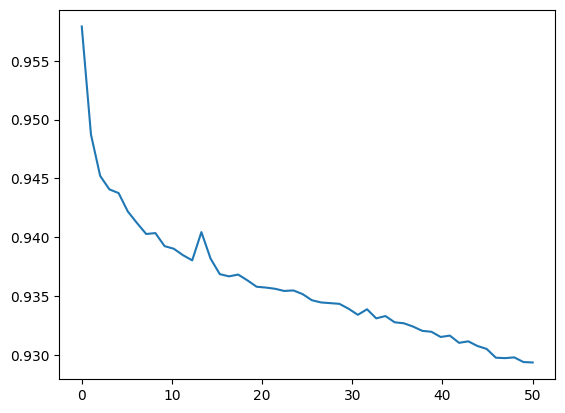

In [ ]:
x = np.linspace(0, EPOCHS, 50)
plt.plot(x, train_loss_list)

In [ ]:
model = UNET()
state_dict = torch.load('model/model1.pth')
model.load_state_dict(state_dict)


<All keys matched successfully>

C:\Users\PC\AppData\Local\Temp\ipykernel_10556\3315199318.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\PC\AppData\Local\Temp\ipykernel_10556\3315199318.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


tensor(1.4415, device='cuda:0')


d:\programming\transformer\venv\lib\site-packages\monai\losses\dice.py:144: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


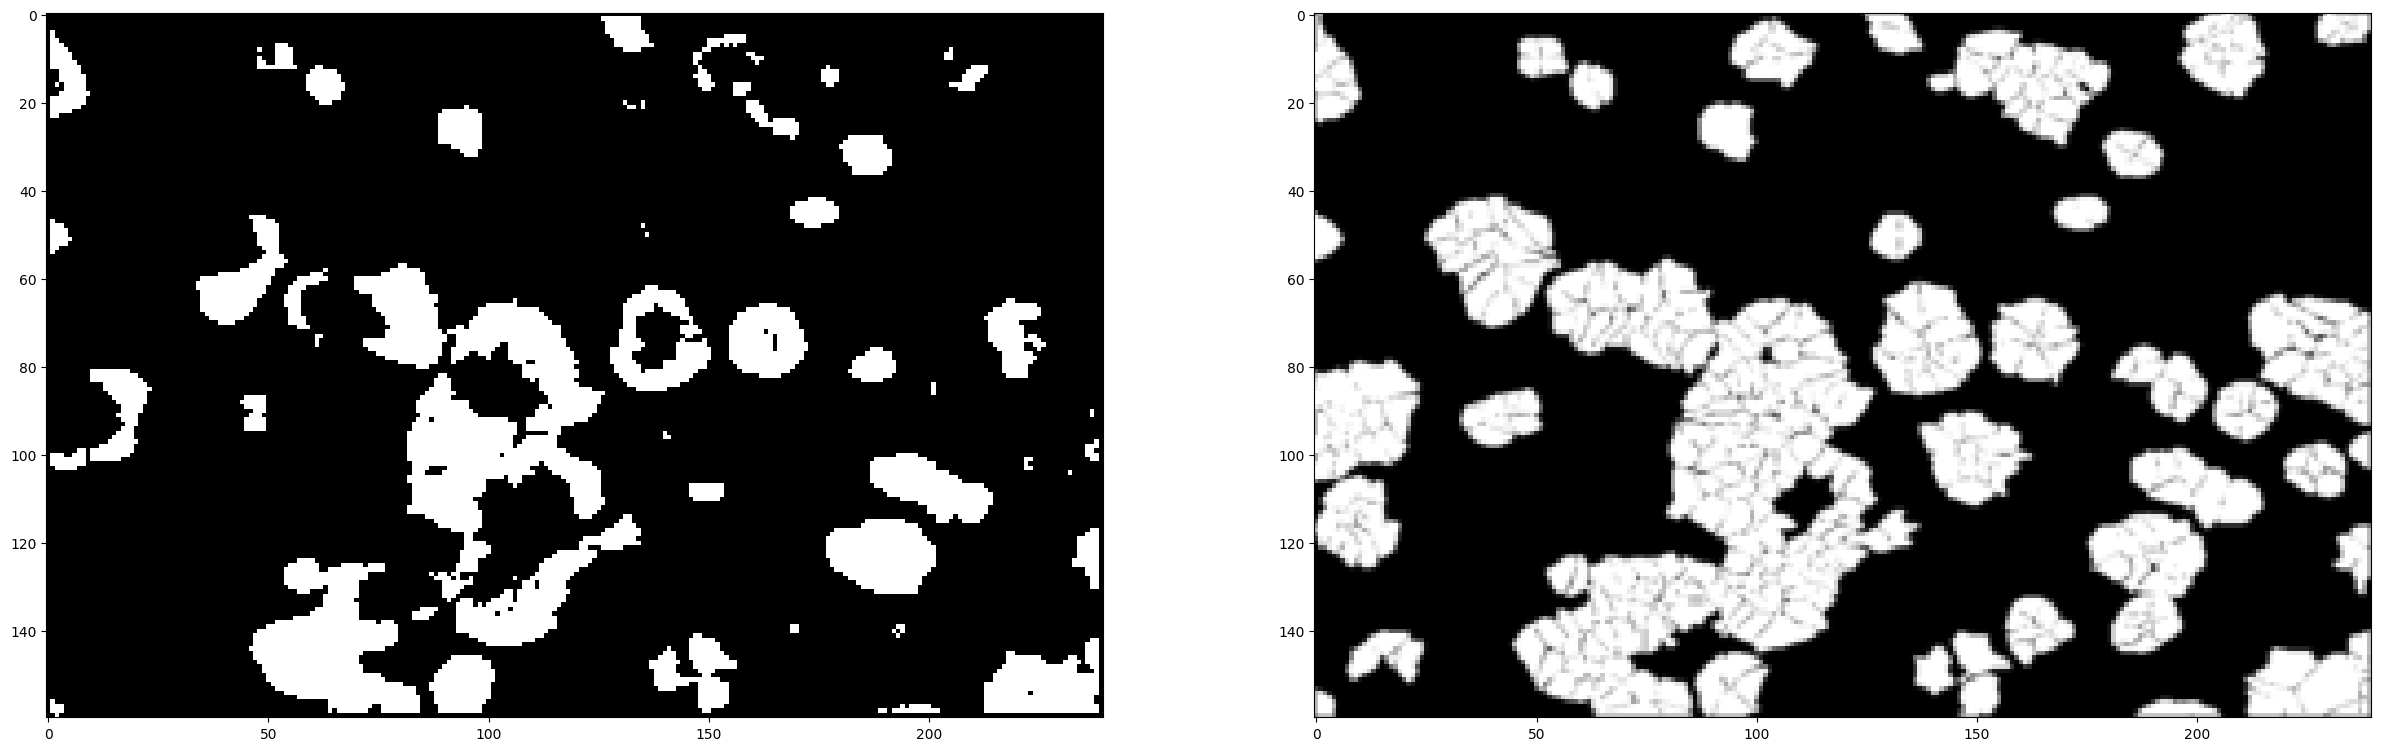

In [ ]:
DEVICE='cuda'
model.to(DEVICE)
model.eval()
input, mask = next(iter(test_loader))
image = input[1].unsqueeze(0)
image = image.to(DEVICE)
mask = mask.to(DEVICE)
preds = torch.sigmoid(model(image))
preds = (preds > 0.5).float()
print(loss_fn(preds, mask[1].unsqueeze(0)))
preds = preds.cpu()
preds = preds.squeeze(0).squeeze(0)
mask = mask[1].squeeze(0).cpu()
fig, ax = plt.subplots(1, 2, figsize=(30,60))
ax[0].imshow(preds, cmap='gray')
ax[1].imshow(mask, cmap='gray')


In [ ]:
model.to(DEVICE)
model.eval()
input, mask = next(iter(test_loader))
image = input[1].unsqueeze(0)
image = image.to(DEVICE)
mask = mask.to(DEVICE)
preds = torch.sigmoid(model(image))
preds = (preds > 0.5).float()
loss_fn(preds, mask[1].unsqueeze(0))

C:\Users\PC\AppData\Local\Temp\ipykernel_10556\3315199318.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\PC\AppData\Local\Temp\ipykernel_10556\3315199318.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


tensor(1.4470, device='cuda:0')